<a href="https://colab.research.google.com/github/mahsasheikh/HybGen/blob/main/HybGen_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **M01 Tool**
A Jupyter Notebook based on AutoDock Vina 1.2.0 written to generate hybrid ligands and perform ✨**automated**✨ docking simulation.
You can run cells one after another to perform your desired action.

---
---
# **Setting up the Environment for Molecular Docking**

Before starting, we need to install all the necessary software and dependecies to perform molecular docking.

+ condacolab (https://github.com/conda-incubator/condacolab)
+ MGLtools (https://ccsb.scripps.edu/mgltools/)
+ AutoDock Vina (https://vina.scripps.edu/)
+ biopython (https://biopython.org/)
+ EasyDock (https://github.com/ci-lab-cz/easydock)
+ PDBFixer (https://github.com/openmm/pdbfixer)
+ RDKit (https://www.rdkit.org/)
+ LABODOCK (https://github.com/RyanZR/labodock/tree/main)

In [1]:
# @title Initializing Condacolab (kernel will restart)

!pip install -q condacolab
import condacolab

condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


In [1]:
# @title Check that everything is fine

import condacolab

condacolab.check()

print("📦 Installing conda dependencies ...")
!conda install -c conda-forge rdkit pdbfixer > /dev/null

✨🍰✨ Everything looks OK!
📦 Installing conda dependencies ...


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.11.3

Please update conda by running

    $ conda update -n base -c conda-forge conda




In [ ]:
# @title Installing dependencies and packages (this might take around 20 minutes)
print("🔥 Installing PyTorch and PyG ...")
!pip install torch==1.13.1+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html > /dev/null
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cpu.html > /dev/null
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cpu.html > /dev/null
!pip install torch-spline-conv torch-geometric==2.0.1 -f https://data.pyg.org/whl/torch-1.13.1+cpu.html > /dev/null
!pip install cairosvg svgutils molvs > /dev/null
# Install other dependencies
!pip install rdkit-pypi
!pip install Bio
!pip install meeko
!pip install paramiko
!pip install easydock
print("✔️ Installing pkasolver package and its dependencies ...")
!pip install -q git+https://github.com/mayrf/pkasolver.git > /dev/null
print("✔️ Ensuring cffi is properly installed ...")
!pip uninstall -y cffi
!pip uninstall -y _cffi_backend
!pip install cffi==1.17.1

print("🎉 Done!")

🔥 Installing PyTorch and PyG ...


In [ ]:
# @title Setup AutoDock Vina
!wget https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.0/vina_1.2.0_linux_x86_64 -O vina
!chmod u+x vina

In [ ]:
# @title **Import Python Modules**

# Standard library imports
import contextlib
import csv
import os
import random
import shutil
import sys
import tempfile
import xml.etree.ElementTree as ET
from itertools import combinations, permutations

# Third-party library imports
import numpy as np
import pandas as pd
import requests
from Bio import PDB
from Bio.PDB import PDBIO, PDBParser

# Custom library imports
from easydock import preparation_for_docking, protonation
from IPython.display import Image, display
from openmm.app import PDBFile
from pdbfixer import PDBFixer
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Draw, rdChemReactions
from rdkit.Chem.rdMolDescriptors import (
    CalcCrippenDescriptors,
    CalcExactMolWt,
    CalcNumLipinskiHBA,
    CalcNumLipinskiHBD,
)


# Capture python output with context manager
class SuppressOutput:
    """Context manager to suppress stdout during function calls."""

    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, "w")

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


# Define common variables for PDB operations
pdb_io = PDBIO()
pdb_parser = PDBParser()


def setup_environment():
    """Print environment setup confirmation."""
    print("> Installation done")
    print("> Import done")
    print("> Environment ready for docking")


setup_environment()

In [ ]:
# @title **Setup alias for Vina**

%alias vina /content/vina

print("> Alias '%Vina' created")


---
---
# **Adding Ligand and Receptor to the Workflow**

The first step in a ligand and receptor docking process is adding or importing your considered molecules to the workflow. This tool allows you to add ligands in SMILES format. This structure can be used directly for ligand-needed preparations before docking or modified by adding new atoms or amino acids in the ligand builder tool.

Receptors can be added just by their PDB or UniProt ID. You can also select a specific chain of the receptor macromolecule.

In [ ]:
SMILES = "CC(ON(C(C)(C)C)C(C)(C)C)C1=CC=C(N)C=C1"  # @param {type:"string"}
PDB_ID = ""  # @param {type:"string"}
chain_in_PDB = None  # @param
uniprot = "q9y006"  # @param {type:"string"}

---
---
# **Generating the Hybrids**

The first step in this study is to have a set of structures of a given ligand, hybridized with proper amino acids. We utilize the RDKit library for molecular manipulations and EasyDock for docking simulations. The core component of this method is the LigandBuilder class, which handles the creation of peptide bonds, removal of extra hydrogens, and the generation of ligands.


*This step is specifically designed for generating hybrids. If you're just interested in automatic docking feature, skip next three cells.*

# **View Primary Ligand Structure**

By running the next cell, you can view your ligand structure submitted in the last step as SMILES. Based on atom numbers, you can choose the connection point. That atom will bond to your favorite amino acids or another molecule you prefer, in the next step.

just keep in mind this tool connects molecules based on peptide amide bonds. You should provide structures with proper atom groups for generating these bonds such as carboxyl or amino groups.

In [ ]:
# @title **Choosing the Connection Point**


def get_all_atoms_in_molecule(molecule):
    """
    Get all atoms in the input molecule.

    This should be done before anything to define your connection point.

    Returns:
        IPython.core.display.Image object: Image displaying the molecule with atom indices.
    """
    # Create a drawing object with a specific size
    d = Draw.MolDraw2DCairo(800, 800)
    # Set the drawing options to show atom indices
    d.drawOptions().addAtomIndices = True
    # Draw the molecule
    d.DrawMolecule(molecule)
    d.FinishDrawing()
    # Get the image data
    data = d.GetDrawingText()
    # Display the image in the notebook
    return Image(data=data)


# Create a molecule from SMILES
molecule = Chem.MolFromSmiles(SMILES)
# Display the molecule with atom indices
display(get_all_atoms_in_molecule(molecule))

ligand_smiles = []

---
---
# **Submit Ligand**

Here you can submit ligand structure to the docking process and skip ligand builder steps. Just run this cell and go straight to the "Docking Folders" cell.


In [8]:
if not ligand_smiles:
    ligand_smiles = [SMILES]

---
---
# **Ligand Builder Settings**

In the connection site text box, you can enter the atom number to connect different molecules based on the ligand structure provided before.
Each amino acid has two stereoisomers, mirror images of one another except for glycine. You can enter the amino acid sequence as any of these two kinds separately by their one-letter symbols.
The next step, lets you choose whether the amino acid chain should make a bond from its C-terminal (carboxyl group) or its N-terminal (amino group). You can set this parameter just by entering C or N.
The last step will provide an option for considering adding molecules to the ligands besides amino acids. Just keep in mind that this molecule could make a peptide bond.


In [9]:
# note that you either can have one non-peptide entry in the "other molecules" or several peptides in multiple sections
connection_site = 16  # @param
# choose N or C terminal of the peptides for connection point
# note that the connection site and the terminal should make chemical sense
terminal = "C"  # @param {type:"string"}
L_sequence = "F"  # @param {type:"string"}
D_sequence = ""  # @param {type:"string"}
# provide a list
other_molecules = ["OC(OC(C)(C)C)=O"]  # @param

---
---
# **Building Ligand**

The code based on variables and their values defined before, will generate ligand structures. The output will be in SMILES and can be used in docking process.

In [12]:
# Suppress RDKit logging
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)


class LigandBuilder:
    def __init__(self):
        self.ligands = []
        self.amino_acid_arrangements = []
        self.molecule = None

    def create_peptide_bond(self, mol1, mol2):
        """
        Create a peptide bond between two molecules using predefined SMARTS patterns.

        Args:
            mol1: First molecule (RDKit Mol object).
            mol2: Second molecule (RDKit Mol object).

        Returns:
            RDKit Mol object representing the combined molecule with a peptide bond, or None if unsuccessful.
        """
        reactions_with_OH = [
            (
                "[C:1](=[O:2])[OH:3]",
                "[N:4]",
                "[C:1](=[O:2])[OH:3].[N:4]>>[C:1](=[O:2])[N:4]",
            ),
            (
                "[N:4]",
                "[C:1](=[O:2])[OH:3]",
                "[N:4].[C:1](=[O:2])[OH:3]>>[C:1](=[O:2])[N:4]",
            ),
        ]
        reactions_without_OH = [
            (
                "[N:4]",
                "[C:1](=[O:2])[O:3]",
                "[N:4].[C:1](=[O:2])[O:3]>>[C:1](=[O:2])[N:4]",
            ),
            (
                "[C:1](=[O:2])[O:3]",
                "[N:4]",
                "[C:1](=[O:2])[O:3].[N:4]>>[C:1](=[O:2])[N:4]",
            ),
        ]

        try:
            for smarts1, smarts2, rxn_smarts in reactions_with_OH:
                if mol1.HasSubstructMatch(
                    Chem.MolFromSmarts(smarts1)
                ) and mol2.HasSubstructMatch(Chem.MolFromSmarts(smarts2)):
                    rxn = rdChemReactions.ReactionFromSmarts(rxn_smarts)
                    products = [p[0] for p in rxn.RunReactants((mol1, mol2)) if p]
                    if products:
                        return products[0]

            for smarts1, smarts2, rxn_smarts in reactions_without_OH:
                if mol1.HasSubstructMatch(
                    Chem.MolFromSmarts(smarts1)
                ) and mol2.HasSubstructMatch(Chem.MolFromSmarts(smarts2)):
                    rxn = rdChemReactions.ReactionFromSmarts(rxn_smarts)
                    products = [p[0] for p in rxn.RunReactants((mol1, mol2)) if p]
                    if products:
                        return products[0]

            print("No suitable reaction found for the given molecules.")
            return None
        except Exception as e:
            print(f"Error creating peptide bond: {e}")
            return None

    def add_hydrogens_and_sanitize(self, mol):
        """
        Add hydrogens and sanitize a molecule.
        """
        try:
            mol = AllChem.AddHs(mol)
            Chem.SanitizeMol(mol)
            return mol
        except Exception as e:
            print(f"Error adding hydrogens or sanitizing molecule: {e}")
            return None

    def remove_extra_hydrogens(self, mol):
        """
        Remove unnecessary hydrogens from the molecule and adjust nitrogen atoms.
        """
        mol = Chem.RemoveHs(mol, sanitize=False)

        for atom in mol.GetAtoms():
            if atom.GetSymbol() == "N":
                valence = atom.GetTotalValence()
                explicit_hs_needed = max(3 - valence, 0)
                atom.SetNumExplicitHs(explicit_hs_needed)
                atom.SetNumRadicalElectrons(0)
                atom.SetNoImplicit(True)

        return mol

    def handle_N_heterocycles(self, mol):
        # Define SMARTS patterns and their corresponding nitrogen indices
        patterns = [
            (
                Chem.MolFromSmarts(
                    "[#6]12:[#6]:[#6]:[#6]:[#6]:[#6]:1:[#6]:[#6]:[#7]:2"
                ),
                -1,
            ),
            (Chem.MolFromSmarts("[#6]1:[#7]:[#6]:[#7]:[#6]:1"), -2),
            (Chem.MolFromSmarts("[#6]1:[#6]:[#7]:[#6]:[#6]:1"), -3),
            (
                Chem.MolFromSmarts(
                    "[#6]12:[#7]:[#6]:[#7]:[#6]:[#6]:1:[#7]:[#6]:[#7]:2"
                ),
                -1,
            ),
            (Chem.MolFromSmarts("[#6]1:[#7]:[#7]:[#7]:[#6]:1"), -2),
            (Chem.MolFromSmarts("[#6]1:[#7]:[#7]:[#7]:[#7]:1"), -1),
            (Chem.MolFromSmarts("[#6]1:[#6]:[#7]:[#7]:[#6]:1"), -2),
        ]

        for pattern, nitrogen_index_offset in patterns:
            if mol.HasSubstructMatch(pattern):
                matches = mol.GetSubstructMatches(pattern)
                for match in matches:
                    # Get the nitrogen atom index from the match
                    nitrogen_index = match[
                        nitrogen_index_offset
                    ]  # Get the nitrogen atom index
                    # Add one explicit hydrogen to the nitrogen atom
                    atom = mol.GetAtomWithIdx(nitrogen_index)
                    if atom.GetTotalDegree() == 2:
                        atom.SetNumExplicitHs(1)

        return mol

    def input_amino_acids(self, l_sequence, d_sequence, other_aminoacids):
        """
        Create molecules from input amino acids and generate all peptide bond combinations.

        Args:
            l_sequence (str): L-amino acids sequence.
            d_sequence (str): D-amino acids sequence.
            other_aminoacids (list): List of additional amino acids or molecules in SMILES format.
        """
        l_mols = [
            Chem.rdmolfiles.MolFromFASTA(f">{aa.upper()}\n{aa.upper()}")
            for aa in l_sequence
        ]
        d_mols = [
            Chem.rdmolfiles.MolFromFASTA(f">{aa.lower()}\n{aa.lower()}", flavor=1)
            for aa in d_sequence
        ]
        other_mols = [
            self.add_hydrogens_and_sanitize(Chem.MolFromSmiles(n))
            for n in other_aminoacids
        ]

        all_mols = l_mols + d_mols + other_mols
        unique_smiles = set()

        for r in range(1, len(all_mols) + 1):
            for combo in combinations(all_mols, r):
                for perm in permutations(combo):
                    peptide = perm[0]
                    for mol in perm[1:]:
                        peptide = self.create_peptide_bond(peptide, mol)

                    try:
                        Chem.SanitizeMol(peptide)
                        peptide = Chem.AddHs(peptide)
                        smiles = Chem.MolToSmiles(peptide, isomericSmiles=True)
                        if smiles not in unique_smiles:
                            unique_smiles.add(smiles)
                            self.amino_acid_arrangements.append(peptide)
                    except Exception:
                        print("Finding right molecule combinations...")

    def input_molecule(self, molecule_smiles):
        """
        Input a molecule from its SMILES string and prepare it.

        Args:
            molecule_smiles (str): SMILES string.
        """
        try:
            self.molecule = Chem.MolFromSmiles(molecule_smiles)
            Chem.SanitizeMol(self.molecule)
            AllChem.Compute2DCoords(self.molecule)
        except Exception as e:
            raise ValueError(f"Error reading SMILES string: {e}")

    def find_connection_points(self, molecule, smarts_pattern="[NH2,NH]"):
        """
        Find all atom indices matching the SMARTS pattern.

        Args:
            molecule: Molecule to search.
            smarts_pattern: SMARTS pattern to match.

        Returns:
            List of atom indices.
        """
        query = Chem.MolFromSmarts(smarts_pattern)
        if not query:
            raise ValueError(f"Invalid SMARTS pattern: {smarts_pattern}")

        return [match[0] for match in molecule.GetSubstructMatches(query)]

    def add_cs_atom(self, connection_site):
        """
        Add a Cesium atom to the molecule at the specified connection site.
        """
        Chem.SanitizeMol(self.molecule)
        edit_mol = Chem.EditableMol(self.molecule)
        edit_mol.AddAtom(Chem.Atom(55))  # Cesium (Cs)
        edit_mol.AddBond(
            connection_site, self.molecule.GetNumAtoms(), Chem.BondType.SINGLE
        )
        self.molecule = edit_mol.GetMol()
        Chem.RemoveHs(self.molecule, sanitize=False)
        return self.molecule

    def generate_ligands(self, connection_site, terminal):
        """
        Generate ligands by combining amino acids and input molecule.

        Args:
            connection_site: Atom index for ligand attachment.
            terminal: 'C' or 'N' indicating attachment point.
        """
        if not hasattr(self, "amino_acid_arrangements") or not hasattr(
            self, "molecule"
        ):
            raise ValueError(
                "Input amino acids and molecule before generating ligands."
            )

        if terminal == "C":
            self.ligands = [
                Chem.ReplaceSubstructs(
                    arr,
                    Chem.MolFromSmarts("[OH]"),
                    Chem.Mol(self.molecule),
                    replacementConnectionPoint=connection_site,
                )
                for arr in self.amino_acid_arrangements
            ]
        elif terminal == "N":
            modified_ligand = self.add_cs_atom(connection_site)
            self.ligands = []
            for arrangement in self.amino_acid_arrangements:
                for connection_point in self.find_connection_points(arrangement):
                    self.ligands.append(
                        Chem.ReplaceSubstructs(
                            Chem.Mol(modified_ligand),
                            Chem.MolFromSmarts("[Cs]"),
                            arrangement,
                            replacementConnectionPoint=connection_point,
                        )
                    )
        else:
            raise ValueError("The argument terminal should be either 'C' or 'N'.")

        self.ligand_smiles = []
        for ligand_tuple in self.ligands:
            for ligand in ligand_tuple:
                ligand = self.remove_extra_hydrogens(ligand)
                ligand = self.handle_N_heterocycles(ligand)
                Chem.SanitizeMol(ligand)
                smiles = Chem.MolToSmiles(ligand)
                print("New ligand SMILES generated.")
                self.ligand_smiles.append(smiles)

        return self.ligand_smiles


# Example usage
builder = LigandBuilder()

# Input data
builder.input_amino_acids(L_sequence, D_sequence, other_molecules)
builder.input_molecule(SMILES)

# Generate ligands
ligand_smiles = builder.generate_ligands(connection_site, terminal)
print(f"{len(ligand_smiles)} ligands generated.")

# Writing the SMILES strings to a CSV file
with open("generated_ligands.csv", "w", newline="") as csvfile:
    fieldnames = ["SMILES"]  # Define the column name
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()  # Write the header

    for smiles in ligand_smiles:
        writer.writerow({"SMILES": smiles})  # Write each SMILES as a row
        print(smiles)

New ligand SMILES generated.
New ligand SMILES generated.
New ligand SMILES generated.
3 ligands generated.
CC(ON(C(C)(C)C)C(C)(C)C)c1ccc([N]C(=O)[C@@H]([N])Cc2ccccc2)cc1
CC(ON(C(C)(C)C)C(C)(C)C)c1ccc([N]C(=O)OC(C)(C)C)cc1
CC(ON(C(C)(C)C)C(C)(C)C)c1ccc([N]C(=O)[C@H](Cc2ccccc2)[N]C(=O)OC(C)(C)C)cc1


---
---
# **Building Ligand**

The code based on variables and their values determined before, will generate ligand structures. The output will be in SMILES and can be used in docking process.

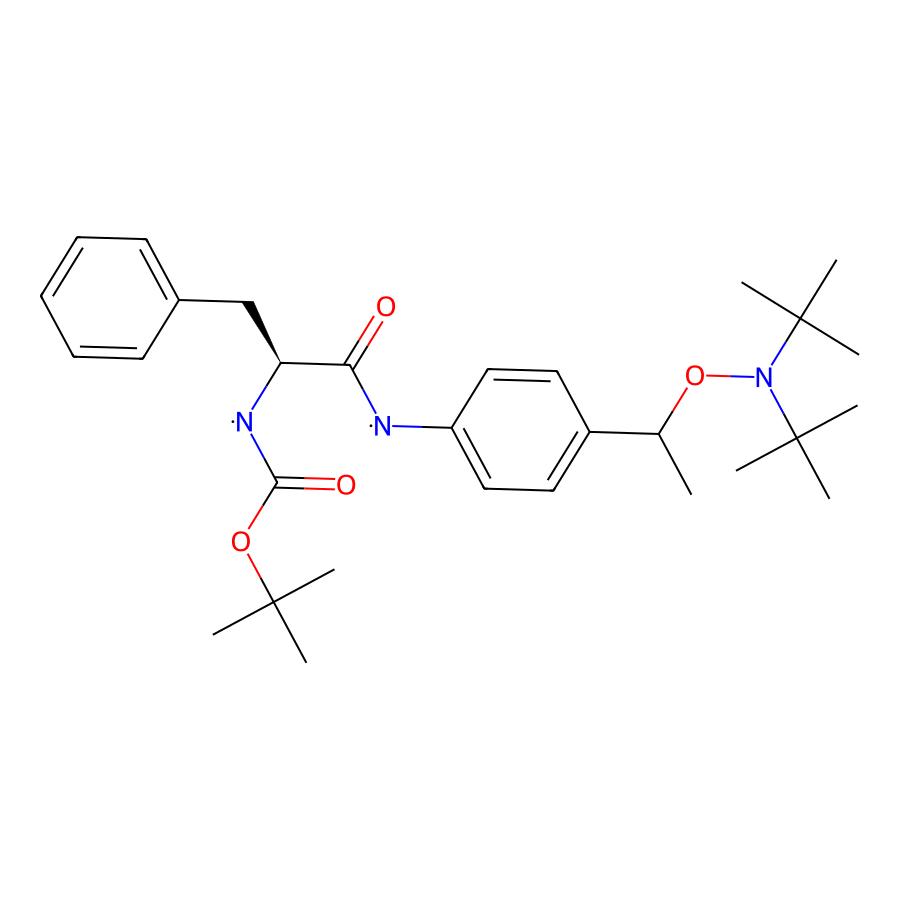

In [ ]:
# @title **display an example**

# Select a random SMILE from the list
random_smile = random.choice(ligand_smiles)

# Create a molecule object from the SMILE
molecule = Chem.MolFromSmiles(random_smile)

# Display the molecule
Draw.MolToImage(molecule, size=(900, 900))


---

# **Uploading a CSV of Selected Ligands (Optional)**

If you want to perform the docking process on a specific set of molecules, you can upload a CSV file containing only your selected ligands. The file should include the ligands' SMILES strings. Molecules from the uploaded file will be docked instead of the generated ones.

Simply drag and drop your file into the main **Files** section and insert the **"file name.csv"** into the cell below.


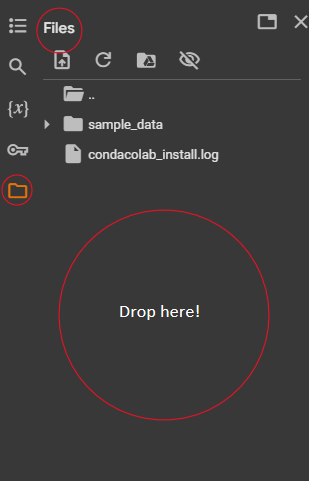

In [15]:
to_be_docked = "generated_ligands.csv"  # @param {type:"string"}
if to_be_docked:
    ligand_smiles = pd.read_csv(to_be_docked, header=0).iloc[:, 0].tolist()  # Read the first column, excluding the header

---
---
# **Docking Folders**

This cell based on UniProt or PDB ID will make folders for keeping necessary files during docking.


In [ ]:
if uniprot:
    Jobname = f"{uniprot}_docking"
else:
    Jobname = f"{PDB_ID}_docking"
dir = os.path.abspath(".")
work_dir = os.path.join(dir, Jobname)
protein_folder = os.path.join(work_dir, "protein")
ligand_folder = os.path.join(work_dir, "ligand")
experimental_folder = os.path.join(work_dir, "experimental")
docking_folder = os.path.join(work_dir, "docking")


# Create folder if folder have not exists
folder = [work_dir, protein_folder, ligand_folder, docking_folder]
for f in folder:
    if os.path.exists(f):
        print("> %s already exists" % f)
    if not os.path.exists(f):
        os.mkdir(f)
        print("> %s was successfully created" % f)

> /content/q9y006_docking already exists
> /content/q9y006_docking/protein already exists
> /content/q9y006_docking/ligand already exists
> /content/q9y006_docking/docking already exists


---
---
# **Preparing the Protein**

The first step in docking is to have a structure of a given target protein. While in some cases a high-quality comparative model will be used, most cases start with an experimentally (X-ray, NMR, cryoEM) solved three-dimensional structure. We can either use uniprot API to select the PDB file and chain or enter them directly.
In these cases, a given target protein structure can be downloaded with BioPython using a given accession ID.  We can directly download this structure in `.pdb` file format.

This cell acquires the receptor structure file from databases across the web and prepares it for docking.

In [ ]:
# get pdb
class SelectChains(PDB.Select):
    """Accepts or rejects chains based on their chain IDs."""

    def __init__(self, chain_letters):
        """Initialize with a list of chain IDs to accept."""
        self.chain_letters = chain_letters

    def accept_chain(self, chain):
        """Accepts a chain if its ID is in the list of accepted IDs."""
        return chain.get_id() in self.chain_letters


class GetPDB:
    """Class for fetching and processing PDB files."""

    def __init__(self, directory, uniprot_id=None, pdb_id=None, chain=None):
        """Initialize with directory path and optional UniProt ID, PDB ID, and chain ID."""
        self.uniprot_id = uniprot_id
        self.pdb_id = pdb_id
        self.chain = chain
        self.directory = directory
        self.PDB_DOWNLOAD_PATH = os.path.join(directory, "pdbs")
        self.CLEAN_PDBS_PATH = directory
        os.makedirs(self.PDB_DOWNLOAD_PATH, exist_ok=True)
        os.makedirs(self.CLEAN_PDBS_PATH, exist_ok=True)

    def fetch_uniprot_data(self):
        """Fetch UniProt data for a given UniProt ID."""
        if not self.uniprot_id:
            return None
        url = f"https://www.uniprot.org/uniprot/{self.uniprot_id}.xml"
        response = requests.get(url)
        if response.status_code == 200:
            return response.text
        else:
            print(f"Error fetching data from UniProt: {response.status_code}")
            return None

    def parse_pdb_entries(self, xml_data):
        """Parse PDB entries from UniProt XML data."""
        root = ET.fromstring(xml_data)
        pdbs = []
        for db_ref in root.findall(
            ".//{http://uniprot.org/uniprot}dbReference[@type='PDB']"
        ):
            pdb = db_ref.attrib["id"]
            method_element = db_ref.find(
                ".//{http://uniprot.org/uniprot}property[@type='method']"
            )
            resolution_element = db_ref.find(
                ".//{http://uniprot.org/uniprot}property[@type='resolution']"
            )
            chains_element = db_ref.find(
                ".//{http://uniprot.org/uniprot}property[@type='chains']"
            )
            if method_element is not None and resolution_element is not None:
                method = method_element.attrib["value"]
                resolution = float(resolution_element.attrib["value"].split()[0])
                chain_details = self.parse_chain_details(chains_element)
                if chain_details:
                    chain_details.sort(key=lambda x: x[1], reverse=True)
                    pdbs.append(
                        (
                            pdb,
                            chain_details[0][0],
                            chain_details[0][1],
                            resolution,
                            method,
                        )
                    )
                else:
                    pdbs.append((pdb, "NA", 0, resolution, method))
        return pdbs

    def parse_chain_details(self, chains_element):
        """Parse chain details from UniProt XML data."""
        chain_details = []
        if chains_element is not None:
            chains_info = chains_element.attrib["value"].split(",")
            for chain_detail in chains_info:
                try:
                    chain, range_ = chain_detail.strip().split("=")
                    chain = chain.split("/")[0]
                    start, end = range_.split("-")
                    aa_count = int(end) - int(start) + 1
                    chain_details.append((chain, aa_count))
                except ValueError:
                    print(
                        f"Skipping chain detail due to unexpected format: {chain_detail}"
                    )
        return chain_details

    def select_best_pdb(self, pdbs):
        """Select the best PDB entry based on chain length and resolution."""
        if not pdbs:
            return None
        pdbs.sort(key=lambda x: (-x[2], x[3]))
        return pdbs[0]

    def process_uniprot_id(self):
        """Process UniProt ID, fetch PDB data, and select the best PDB entry."""
        xml_data = self.fetch_uniprot_data()
        if xml_data:
            pdbs = self.parse_pdb_entries(xml_data)
            if pdbs:
                return self.select_best_pdb(pdbs)
        return None

    def calculate_centroid(self, structure):
        """Calculate the centroid of a PDB structure."""
        atom_coords = [atom.get_coord() for atom in structure.get_atoms()]
        return np.mean(atom_coords, axis=0)

    def make_pdb(
        self, pdb_path, chain_letters, base_dir=None, overwrite=True, struct=None
    ):
        """Extract a specific chain from a PDB file and save it to a temporary directory."""
        self.parser = PDB.PDBParser()
        self.writer = PDB.PDBIO()
        self.base_dir = base_dir if base_dir else self.directory
        if isinstance(chain_letters, str):
            chain_letters = [chain_letters]  # Ensure it's iterable

        out_name = f"{self.pdb_id}_{''.join(chain_letters)}.ent"
        out_path = os.path.join(
            self.base_dir, "pdbs", out_name
        )  # Temporary outputs to directory/pdbs

        if not overwrite and os.path.exists(out_path):
            print(
                f"Chain {','.join(chain_letters)} of '{self.pdb_id}' already extracted to '{out_name}'."
            )
            return out_path

        print(f"Extracting chain {','.join(chain_letters)} from {self.pdb_id}...")
        if struct is None:
            struct = self.parser.get_structure(self.pdb_id, pdb_path)

        self.writer.set_structure(struct)
        self.writer.save(out_path, select=SelectChains(chain_letters))
        print("Other chain removed ...")

        pdb = self.parser.get_structure(self.pdb_id, out_path)
        io = PDB.PDBIO()
        io.set_structure(pdb)
        clean_path = os.path.join(
            self.CLEAN_PDBS_PATH,
            f"receptor_{self.pdb_id}_{''.join(chain_letters)}-cl.pdb",
        )  # Final output to CLEAN_PDBS_PATH
        io.save(clean_path)

        struct = self.parser.get_structure(self.pdb_id, clean_path)
        centroid = self.calculate_centroid(struct)
        centroid_info = f"REMARK Centroid X: {centroid[0]:.3f} Y: {centroid[1]:.3f} Z: {centroid[2]:.3f}\n"  # add centroid to PDB file

        with open(clean_path, "r+") as file:
            content = file.readlines()
            content.insert(0, centroid_info)
            file.seek(0)
            file.writelines(content)

        print("Het atoms removed and centroid added...")
        return clean_path, self.CLEAN_PDBS_PATH, centroid

    def pdbfixer(self, clean_path, CLEAN_PDBS_PATH, centroid):
        """Use PDBFixer to fix missing atoms and residues in a PDB file."""
        fixer = PDBFixer(filename=clean_path)
        fixer.findMissingResidues()
        fixer.findNonstandardResidues()
        fixer.replaceNonstandardResidues()
        fixer.removeHeterogens(False)
        fixer.findMissingAtoms()
        fixer.addMissingAtoms()
        fixed_path = os.path.join(
            CLEAN_PDBS_PATH, f"{os.path.basename(clean_path).split('.')[0]}-fixed.pdb"
        )
        PDBFile.writeFile(fixer.topology, fixer.positions, open(fixed_path, "w"))

        centroid_info = f"REMARK Centroid X: {centroid[0]:.3f} Y: {centroid[1]:.3f} Z: {centroid[2]:.3f}\n"
        with open(fixed_path, "r+") as file:
            content = file.readlines()
            content.insert(0, centroid_info)
            file.seek(0)
            file.writelines(content)

        print(f"PDB file fixed in {fixed_path}")

    def get_pdb_from_uniprot(self):
        pdb_data = self.process_uniprot_id()
        if not pdb_data:
            print("Skipping entry because of missing PDB data.")
            return None, None

        self.pdb_id, self.chain = pdb_data[:2]

        if not self.pdb_id or not self.chain:
            print("Skipping entry because of missing PDB ID or Chain.")
            return None, None
        else:
            print(f"Processing PDB ID {self.pdb_id} with chain {self.chain}...")
            try:
                pdb_fn = PDB.PDBList().retrieve_pdb_file(
                    self.pdb_id, pdir=self.PDB_DOWNLOAD_PATH, file_format="pdb"
                )
                clean_path, CLEAN_PDBS_PATH, centroid = self.make_pdb(
                    pdb_fn, self.chain
                )
                self.pdbfixer(clean_path, self.CLEAN_PDBS_PATH, centroid)
                return self.pdb_id, self.chain
            except Exception as e:
                print(
                    f"Error processing PDB ID {self.pdb_id} with chain {self.chain}: {e}"
                )
                return None, None

    def get_pdb_from_PDB(self):
        if not self.pdb_id or not self.chain:
            print("Skipping entry because no PDB or chain was enterd.")
            return None, None
        else:
            print(f"Processing PDB ID {self.pdb_id} with chain {self.chain}...")
            try:
                pdb_fn = PDB.PDBList().retrieve_pdb_file(
                    self.pdb_id, pdir=self.PDB_DOWNLOAD_PATH, file_format="pdb"
                )
                clean_path, CLEAN_PDBS_PATH, centroid = self.make_pdb(
                    pdb_fn, self.chain
                )
                self.pdbfixer(clean_path, self.CLEAN_PDBS_PATH, centroid)
                return self.pdb_id, self.chain
            except Exception as e:
                print(
                    f"Error processing PDB ID {self.pdb_id} with chain {self.chain}: {e}"
                )
                return None, None


# Check which identifier is provided and activate the corresponding method
if uniprot:  # If a UniProt ID is provided
    get_pdb_instance = GetPDB(directory=protein_folder, uniprot_id=uniprot)
    PDB_ID, chain = get_pdb_instance.get_pdb_from_uniprot()
elif PDB_ID:  # If a PDB ID is provided
    get_pdb_instance = GetPDB(directory=protein_folder, pdb_id=PDB_ID, chain=chain_in_PDB)
    PDB_ID, chain = get_pdb_instance.get_pdb_from_PDB()
else:
    raise ValueError("Either a UniProt ID or a PDB ID must be provided.")


Processing PDB ID 3QVC with chain A...
Structure exists: '/content/q9y006_docking/protein/pdbs/pdb3qvc.ent' 
Extracting chain A from 3QVC...
Other chain removed ...
Het atoms removed and centroid added...
PDB file fixed in /content/q9y006_docking/protein/receptor_3QVC_A-cl-fixed.pdb


---
---
# **Preparing the Ligand with easydock**
We now need to prepare the ligand that will be used for docking analysis. We will attempt to predict the docking pose onto the binding of target protein.


In [ ]:
# @title protonation loop
# Create temporary files with proper extensions
tmp_input_path = tempfile.NamedTemporaryFile(suffix=".smi", delete=False).name
tmp_output_path = tempfile.NamedTemporaryFile(suffix=".smi", delete=False).name

protonated_smiles = []
for ligand in ligand_smiles:
    # Write SMILES to input file
    with open(tmp_input_path, "w") as tmp_input:
        tmp_input.write(ligand + "\n")  # Ensure correct format for SMILES

    # Protonate using PKASolver
    protonation.protonate_pkasolver(tmp_input_path, tmp_output_path)

    # Read protonated molecule from output file
    with open(tmp_output_path, "r") as tmp_output:
        protonated_smile = tmp_output.read().strip()
        protonated_smiles.append(protonated_smile)

[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.
/usr/local/lib/python3.10/site-packages/pkasolver/query.py:121: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(np.average(consensus_r, axis=0)),
/usr/local/lib/python3.10/site-packages/pkasolver/query.py:122: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(np.std(consensus_r, axis=0)),
[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.
/usr/local/lib/python3.10/site-packages/pkasolver/query.py:121: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated

In [ ]:
print(protonated_smiles)

['CC(ON(C(C)(C)C)C(C)(C)C)c1ccc([N]C(=O)[C@@H]([N])Cc2ccccc2)cc1\tCC(ON(C(C)(C)C)C(C)(C)C)c1ccc([N]C(=O)[C@@H]([N])Cc2ccccc2)cc1', 'CC(ON(C(C)(C)C)C(C)(C)C)c1ccc([N]C(=O)OC(C)(C)C)cc1\tCC(ON(C(C)(C)C)C(C)(C)C)c1ccc([N]C(=O)OC(C)(C)C)cc1', 'CC(ON(C(C)(C)C)C(C)(C)C)c1ccc([N]C(=O)[C@H](Cc2ccccc2)[N]C(=O)OC(C)(C)C)cc1\tCC(ON(C(C)(C)C)C(C)(C)C)c1ccc([N]C(=O)[C@H](Cc2ccccc2)[N]C(=O)OC(C)(C)C)cc1']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---
---
# **Setting Up Molecular Docking**
MGLTools is needed for preparing molecules before docking.


In [ ]:
!conda install bioconda::mgltools

Channels:
 - conda-forge
 - bioconda
Platform: linux-64
Solving environment: - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.11.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bioconda::mgltools


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    mgltools-1.5.7             |       h9ee0642_1       107.0 MB  bioconda
    ------------------------------------------------------------
                                           Total:       107.0 MB

The following NEW packages will be INSTALLED:

  mgltools           bioconda/linux-64::mgltools-1.5.7-h9ee0642_1 



                                                                        
Preparing transaction: / - \ | done
Verifying

---
---
# **Save Prepared Ligands**
Convert ligands to PDBQT format and save SMILES as `.smi` files.

In [ ]:
from rdkit import Chem

# Monkey-patch the Mol class
def has_query(self):
    return False

Chem.Mol.HasQuery = has_query  # Add HasQuery method to all Mol objects

for idx, smile in enumerate(protonated_smiles, start=1):
    smile = smile.split("\t")[0].strip()
    ligand_name = f"lig_hybrid_{idx}"

    # Save the ligand in .smi format
    ligand_smi_path = os.path.join(ligand_folder, f"{ligand_name}.smi")
    with open(ligand_smi_path, "w") as file:
        file.write(smile)

    print(f"Ligand {ligand_name} saved as SMILES (.smi).")

    # Prepare the PDBQT file for docking
    ligand_pdbqt = f"{ligand_name}.pdbqt"
    ligand_pdbqt_path = os.path.join(docking_folder, ligand_pdbqt)

    # Prepare the molecule and ligand for docking
    protonated_mol = preparation_for_docking.mol_from_smi_or_molblock(smile)
    prepared_ligand = preparation_for_docking.ligand_preparation(protonated_mol)

    # Write the prepared ligand to the PDBQT file
    with open(ligand_pdbqt_path, "w") as file:
        file.write(prepared_ligand)

    print(f"Ligand {ligand_name} saved as PDBQT.")

print("> Finished processing all ligands.")


Ligand lig_hybrid_1 saved as SMILES (.smi).
Maybe this molecule is "too" symmetric?  CC(ON(C(C)(C)C)C(C)(C)C)c1ccc([N]C(=O)[C@@H]([N])Cc2ccccc2)cc1
Ligand lig_hybrid_1 saved as PDBQT.
Ligand lig_hybrid_2 saved as SMILES (.smi).
Maybe this molecule is "too" symmetric?  CC(ON(C(C)(C)C)C(C)(C)C)c1ccc([N]C(=O)OC(C)(C)C)cc1
Ligand lig_hybrid_2 saved as PDBQT.
Ligand lig_hybrid_3 saved as SMILES (.smi).
Maybe this molecule is "too" symmetric?  CC(ON(C(C)(C)C)C(C)(C)C)c1ccc([N]C(=O)[C@H](Cc2ccccc2)[N]C(=O)OC(C)(C)C)cc1
Ligand lig_hybrid_3 saved as PDBQT.
> Finished processing all ligands.


---
---
# **Save Prepared Receptor**
This cell will do the last modifications, such as adding polar hydrogens to the structure, and saves it as a `.pdbqt` file.

In [ ]:
# Define the target protein files and paths based on PDB ID and chain
target_protein = f"receptor_{PDB_ID}_{chain[0]}-cl-fixed.pdb"
protein_base = os.path.splitext(target_protein)[0]

# Define file paths for PDB and PDBQT formats
protein_pdb = protein_base + ".pdb"
protein_pdbqt = protein_base + ".pdbqt"

protein_pdb_path = os.path.join(protein_folder, protein_pdb)
protein_pdb_docking_path = os.path.join(docking_folder, protein_pdb)
protein_pdbqt_docking_path = os.path.join(docking_folder, protein_pdbqt)

# Add polar hydrogens and parameterize using MGLTools
prepare_command = f"prepare_receptor4.py -r {protein_pdb_path} -o {protein_pdbqt_docking_path} -A checkhydrogens -U nphs"
os.system(prepare_command)

# Copy the PDB file to the docking folder for later use
shutil.copy(protein_pdb_path, docking_folder)

# Print success message
print(f"> {protein_pdbqt} successfully created in {docking_folder}")

> receptor_3QVC_A-cl-fixed.pdbqt successfully created in /content/q9y006_docking/docking


---
---
# **Grid Box Generation**
It is necessary to define search space that calculates interactions between different poses of ligand and receptor. This three-dimensional space is called grid box. The grid box is usually centered within the binding, active or allosteric site of target protein and its size should be sufficiently enough such that important binding residues are contained inside the box.
**Default centroid is calculated at the center of the receptor chain.**

In [ ]:
def extract_centroid_from_pdb(pdb_filepath):
    """
    Extracts the centroid coordinates from a PDB file. The centroid is indicated
    by a line starting with 'REMARK Centroid' in the PDB file.

    Parameters:
    - pdb_filepath (str): The path to the PDB file.

    Returns:
    - tuple: A tuple (x, y, z) representing the centroid coordinates if found.
    - None: If no centroid line is found.
    """
    with open(pdb_filepath, "r") as pdb_file:
        for line in pdb_file:
            if line.startswith("REMARK Centroid"):
                parts = line.split()
                try:
                    x, y, z = float(parts[3]), float(parts[5]), float(parts[7])
                    return x, y, z
                except (ValueError, IndexError):
                    print(f"Error parsing centroid coordinates from line: {line}")
                    return None
    return None  # In case no centroid line is found


# Example usage
centroid_coords = extract_centroid_from_pdb(protein_pdb_path)
if centroid_coords:
    X, Y, Z = centroid_coords
    print(f"Centroid extracted: X={X}, Y={Y}, Z={Z}")
else:
    print("Centroid not found in the PDB file.")

Centroid extracted: X=-8.942, Y=3.821, Z=-21.626


In [ ]:
# @title Create docking configuration file
def create_config_file(
    docking_folder,
    protein_name,
    center_coords,
    box_dimensions,
    config_filename="config_file.txt",
):
    """
    Creates an AutoDock Vina configuration file for docking.

    Parameters:
    - docking_folder (str): Directory where the config file will be saved.
    - protein_name (str): Name of the receptor protein file (with extension).
    - center_coords (tuple): Coordinates (X, Y, Z) for the docking box center.
    - box_dimensions (tuple): Dimensions (WIDTH, HEIGHT, LENGTH) for the docking box.
    - config_filename (str): Name of the configuration file to be created (default: "config_file.txt").

    Returns:
    - config_filepath (str): The path to the created config file.
    """
    # Unpack the coordinates and dimensions
    center_x, center_y, center_z = map(int, center_coords)
    size_x, size_y, size_z = map(int, box_dimensions)

    # Prepare the config file path
    config_filepath = os.path.join(docking_folder, config_filename)

    # Write the configuration to the file
    with open(config_filepath, "w") as config_file:
        config_file.write(f"receptor = {protein_name}\n\n")
        config_file.write(f"center_x = {center_x}\n")
        config_file.write(f"center_y = {center_y}\n")
        config_file.write(f"center_z = {center_z}\n\n")
        config_file.write(f"size_x = {size_x}\n")
        config_file.write(f"size_y = {size_y}\n")
        config_file.write(f"size_z = {size_z}\n")

    print(f"> {config_filename} successfully created in {docking_folder}")

    return config_filepath


# Example usage
box_dimensions = (126, 126, 126)  # Default box dimensions

# Create the configuration file
config_dfile = create_config_file(
    docking_folder, protein_pdbqt, centroid_coords, box_dimensions
)

> config_file.txt successfully created in /content/q9y006_docking/docking


---
---
# **Performing Molecular Docking**
Autodock Vina will perform the docking stimulation. The simulation runtime varies per the number of ligands and their structure.

In [ ]:
def execute_vina_docking(
    docking_folder,
    config_file,
    cpu=4,
    seed=-224378816,
    exhaustiveness=2,
    num_modes=10,
    energy_range=3,
):
    """
    Executes AutoDock Vina for all ligand files in the docking folder.

    Parameters:
    - docking_folder (str): Directory containing ligand PDBQT files.
    - config_file (str): Path to the AutoDock Vina configuration file.
    - cpu (int): Number of CPU cores to use (default=4).
    - seed (int): Random seed for reproducibility (default=-224378816).
    - exhaustiveness (int): Vina exhaustiveness level (default=32).
    - num_modes (int): Number of output docking modes (default=10).
    - energy_range (int): Energy range for considering docking modes (default=3).

    Returns:
    - None: Executes docking for each ligand and writes the log/output files.
    """
    os.chdir(docking_folder)

    # Fetch all ligand PDBQT files
    ligand_files = [
        file
        for file in os.listdir()
        if file.startswith("lig") and file.endswith(".pdbqt")
    ]
    print(f"Found ligand files: {ligand_files}")

    docking_count = 1
    for ligand_file in ligand_files:
        ligand_base_name = ligand_file[:-6]  # Remove '.pdbqt' to get the ligand name
        ligand_output_pdbqt = f"output_{ligand_base_name}_output.pdbqt"
        ligand_log_txt = f"output_{ligand_base_name}_log.txt"

        ligand_output_pdbqt_path = os.path.join(docking_folder, ligand_output_pdbqt)
        ligand_log_txt_path = os.path.join(docking_folder, ligand_log_txt)

        run_vina_docking(
            ligand_file,
            ligand_output_pdbqt_path,
            ligand_log_txt_path,
            config_file,
            cpu,
            seed,
            exhaustiveness,
            num_modes,
            energy_range,
        )

        # Clean up the log file (remove first line)
        clean_log_file(ligand_log_txt_path)

        print(f"> Molecular docking number {docking_count} completed")
        docking_count += 1


def run_vina_docking(
    ligand_file,
    output_pdbqt_path,
    log_txt_path,
    config_file,
    cpu,
    seed,
    exhaustiveness,
    num_modes,
    energy_range,
):
    """
    Runs AutoDock Vina docking for a single ligand and writes the output to files.

    Parameters:
    - ligand_file (str): Path to the ligand PDBQT file.
    - output_pdbqt_path (str): Path to save the docking output PDBQT.
    - log_txt_path (str): Path to save the docking log.
    - config_file (str): Path to the AutoDock Vina configuration file.
    - cpu (int): Number of CPU cores to use.
    - seed (int): Random seed for reproducibility.
    - exhaustiveness (int): Vina exhaustiveness level.
    - num_modes (int): Number of output docking modes.
    - energy_range (int): Energy range for considering docking modes.

    Returns:
    - None: Executes Vina and writes output files.
    """
    with open(log_txt_path, "w") as log_file:
        with contextlib.redirect_stdout(log_file):
            %vina --config $config_file --ligand $ligand_file --out $output_pdbqt_path --cpu $cpu --seed $seed --exhaustiveness $exhaustiveness --num_modes $num_modes --energy_range $energy_range


def clean_log_file(log_file_path):
    """
    Cleans up the log file by removing the first line.

    Parameters:
    - log_file_path (str): Path to the log file to clean.

    Returns:
    - None: Removes the first line in the log file.
    """
    with open(log_file_path, "r") as log_file:
        lines = log_file.readlines()

    with open(log_file_path, "w") as log_file:
        log_file.writelines(lines[1:])


# Example usage
execute_vina_docking(docking_folder, config_dfile)


Found ligand files: ['lig_hybrid_3.pdbqt', 'lig_hybrid_2.pdbqt', 'lig_hybrid_1.pdbqt']
> Molecular docking number 1 completed
> Molecular docking number 2 completed
> Molecular docking number 3 completed


---
---
# **Molecular Descriptors**
This cell calculates various molecular descriptors using the RDKit module. These descriptors provide insights into the chemical properties of molecules and their potential drug-likeness.

In [ ]:
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt, CalcTPSA
from rdkit.Chem import QED

def extract_smiles_from_pdbqt(file_path):
    """
    Extracts the SMILES string from a PDBQT file.

    Parameters:
    - file_path (str): Path to the PDBQT file.

    Returns:
    - smiles (str): Extracted SMILES string, or None if not found.
    """
    with open(file_path, "r") as file:
        for line in file:
            if line.startswith("REMARK SMILES"):
                parts = line.split()
                if len(parts) > 2:  # Ensure SMILES exists
                    return parts[2]
    return None

def calculate_lipinski_descriptors(smiles):
    """
    Calculates Lipinski descriptors and Lipinski score for a given SMILES string.

    Parameters:
    - smiles (str): SMILES string of the molecule.

    Returns:
    - lipinski_score (int): Lipinski rule score.
    - exact_mw (float): Exact molecular weight.
    - logp (float): LogP value (lipophilicity).
    - hbd (int): Number of hydrogen bond donors.
    - hba (int): Number of hydrogen bond acceptors.
    - tpsa (float): Topological Polar Surface Area (TPSA).
    - qed (float): Quantitative Estimate of Drug-likeness (QED).
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None, None, None, None, None, None  # Handle invalid SMILES

    # Lipinski descriptors
    exact_mw = CalcExactMolWt(mol)
    logp, _ = CalcCrippenDescriptors(mol)
    hbd = CalcNumLipinskiHBD(mol)
    hba = CalcNumLipinskiHBA(mol)

    # Lipinski rule violations
    lipinski_violations = sum(
        [1 for condition in [exact_mw > 500, logp > 5, hbd > 5, hba > 10] if condition]
    )

    # Calculate Lipinski score (4 rules - violations)
    lipinski_score = 4 - lipinski_violations

    # Additional descriptors
    qed = QED.qed(mol)
    tpsa = CalcTPSA(mol)


    return lipinski_score, exact_mw, logp, hbd, hba, tpsa, qed


def process_molecular_descriptors(directory_path):
    """
    Processes all PDBQT files in the directory, extracts SMILES, and calculates Lipinski descriptors.

    Parameters:
    - directory_path (str): Path to the directory containing PDBQT files.

    Returns:
    - DataFrame: DataFrame containing ligand names and their calculated descriptors.
    """
    pdbqt_files = [f for f in os.listdir(directory_path) if f.endswith("output.pdbqt")]
    results = []

    for file_name in pdbqt_files:
        file_path = os.path.join(directory_path, file_name)
        smiles = extract_smiles_from_pdbqt(file_path)

        if smiles:
            lip_score, exact_mw, logp, hbd, hba, tpsa, qed = calculate_lipinski_descriptors(smiles)
            if lip_score is not None:
                ligand_name = file_name.split("_")[1] + file_name.split("_")[3].replace(
                    ".pdbqt", ""
                )
                results.append(
                    {
                        "ligand": ligand_name,
                        "lip_score": lip_score,
                        "exact_mw": exact_mw,
                        "logp": logp,
                        "hbd": hbd,
                        "hba": hba,
                        "tpsa": tpsa,
                        "qed": qed
                    }
                )

    return pd.DataFrame(results)


# Example usage
lipsinki_results = process_molecular_descriptors(docking_folder)


In [ ]:
# @title **saving docking results to a csv file**
def extract_affinity_from_log(file_path):
    """
    Extracts the affinity from the first docking mode in the log file.

    Parameters:
    - file_path (str): Path to the docking log file.

    Returns:
    - affinity (float): The affinity value of the first mode, or None if not found.
    """
    with open(file_path, "r") as file:
        for line in file:
            if line.startswith(
                "   1      "
            ):  # Ensure exact match for the docking mode line
                parts = line.split()
                affinity = float(
                    parts[1]
                )  # Affinity is assumed to be the second element
                return affinity
    return None


def write_results_to_csv(results, output_path):
    """
    Writes docking results to a CSV file.

    Parameters:
    - results (list): List of dictionaries containing 'ligand' and 'affinity'.
    - output_path (str): Path to save the CSV file.
    """
    with open(output_path, "w", newline="") as csvfile:
        fieldnames = ["ligand", "affinity"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for result in results:
            writer.writerow(result)


def process_log_files(directory_path):
    """
    Processes all docking log files in a given directory and saves the results to a CSV file.

    Parameters:
    - directory_path (str): Path to the directory containing log files.

    Returns:
    - output_csv_path (str): Path to the generated CSV file.
    - top_affinity (float): The best affinity score found in the logs.
    """
    log_files = [f for f in os.listdir(directory_path) if f.endswith("log.txt")]
    results = []

    for log_file in log_files:
        ligand = (
            log_file.split("_")[1] + log_file.split("_")[3]
        )  # Parse ligand name from the file name
        file_path = os.path.join(directory_path, log_file)
        affinity = extract_affinity_from_log(file_path)
        if affinity is not None:
            results.append({"ligand": ligand, "affinity": affinity})

    # Determine the output CSV file path
    output_csv_path = os.path.join(directory_path, "docking_results.csv")

    # Write results to CSV
    write_results_to_csv(results, output_csv_path)
    print(f"Results saved to CSV file: {output_csv_path}")

    # Return the top affinity score for further use (optional)
    top_affinity = min(result["affinity"] for result in results) if results else None
    return top_affinity, output_csv_path


# Example Usage
top_score, output_csv_path = process_log_files(docking_folder)

Results saved to CSV file: /content/q9y006_docking/docking/docking_results.csv


---
---
# **Saving Final Results**
Both results of docking and molecular descriptors calculation will be used together for selecting best ligands interacting with the receptor.

In [ ]:
def load_dataframe(file_path):
    """Load a CSV file into a pandas DataFrame."""
    return pd.read_csv(file_path)


def merge_dataframes(lipsinki_results_left, lipsinki_results_right, key_column):
    """Merge two DataFrames on the specified key column."""
    return pd.merge(lipsinki_results_left, lipsinki_results_right, on=key_column)


def save_dataframe(lipsinki_results, output_path):
    """Save the DataFrame to a CSV file."""
    lipsinki_results.to_csv(output_path, index=False)


def save_final_results(lipsinki_results, output_csv_path, final_output_path):
    """
    Merge the existing dataframe with another dataframe from a CSV file
    and save the final result to a new CSV file.
    """
    lipsinki_results_loaded = load_dataframe(output_csv_path)
    final_lipsinki_results = merge_dataframes(lipsinki_results, lipsinki_results_loaded, key_column="ligand")
    save_dataframe(final_lipsinki_results, final_output_path)


# Example Usage
final_output_path = "/content/final_results.csv"
save_final_results(lipsinki_results, output_csv_path, final_output_path)